<a href="https://colab.research.google.com/github/Lzino/TIL_Today-I-Learned/blob/master/Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분석 과제

## 1. 실험 배경 및 목적
- 7일 이상 미접속 유저 대상 LMS 마케팅 효과 측정
- 실험군(target) vs 대조군(control) 무작위 배정, 레벨별 특화 메시지
- 복귀 효과/모델링 통한 타겟팅 전략 수립

### 가설 (hypothesis)
- 메세지를 받고 복귀한 유저들이 새로운 컨텐츠 소비로 인해 대조군 대비 더 많이 활동할것이다.
- Seg마다 복귀율이 다를 것이다. 예를들면 이탈 전 구매를 했거나 고레벨 유저들은 복귀율이 높을 것이다.

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! ls 'drive/MyDrive/Colab Notebooks/NEXON/'

audience.csv  ml엔지니어_실무과제_외부용.pdf  NEXON.ipynb
connect.csv   NEXON_Draft.ipynb		      payment.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='NanumGothic')
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, roc_auc_score, average_precision_score,
                             classification_report, confusion_matrix, precision_recall_curve)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')  # 모든 Warning 숨기기

## 데이터셋 소개

이 실험에서는 총 3개의 데이터셋을 활용합니다.

### 1. audience.csv  (문자 발송 대상자 정보)

| 컬럼명         | 설명                                  | 유형     | 비고                        |
| ------------- | ------------------------------------- | ------- | -------------------------- |
| userid        | 유저 고유 식별자                      | str     |                            |
| type          | 문자 발송 여부 (target/control)        | str     | target: 발송, control: 미발송 |
| level_seg     | 캐릭터 레벨 구간 (1~5)                | int     | 숫자가 클수록 고레벨        |
| sum_cashusage | 이탈 전 누적 결제 금액 (원)            | int     |                            |
| genderytype   | 유저 성별                             | str     | 남/여                      |
| age           | 유저 나이                             | int     |                            |

---

### 2. connect.csv  (접속 이력 데이터)

| 컬럼명         | 설명                                | 유형   | 비고        |
| ------------- | ----------------------------------- | ------ | ----------- |
| userid        | 유저 고유 식별자                    | str    |             |
| sdate         | 접속 날짜 (YYYY-MM-DD)              | date   |             |
| totalplaytime | 당일 플레이 시간(분)                 | int    |             |

---

### 3. payment.csv  (결제 이력 데이터)

| 컬럼명     | 설명                      | 유형   | 비고           |
| ---------- | ------------------------- | ------ | -------------- |
| userid     | 유저 고유 식별자          | str    |                |
| sdate      | 결제 일자 (YYYY-MM-DD)    | date   |                |
| itemno     | 결제한 아이템 식별자      | str    |                |
| payamount  | 결제 금액(원)             | int    |                |

---

**참고**
- 문자 발송일은 2024년 11월 14일이며, 실험 분석 기간은 문자 발송 전/후 1주일입니다.
- 각 데이터셋은 `userid`를 기준으로 join/merge가 가능합니다.


In [5]:
audience_df = pd.read_csv('drive/MyDrive/Colab Notebooks/NEXON/audience.csv')
payment_df = pd.read_csv('drive/MyDrive/Colab Notebooks/NEXON/payment.csv')
connect_df = pd.read_csv('drive/MyDrive/Colab Notebooks/NEXON/connect.csv')

In [6]:
'''
sum_cashusage, gendertype, age의 13,644 결측치 처리가 필요합니다.
'''
display(Markdown("#### [audience_df 정보]"))
connect_df.info()
print('\n')
display(Markdown("#### [audience_df 데이터 프레임]"))
display(audience_df.head())
print('\n')
display(Markdown("#### [audience_df 통계]"))
display(audience_df.describe(include='all'))
print('\n')
display(Markdown("#### [audience_df 결측치 현황]"))
display(audience_df.isnull().sum())

#### [audience_df 정보]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831221 entries, 0 to 831220
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   userid         831221 non-null  int64 
 1   sdate          831221 non-null  object
 2   totalplaytime  831221 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 19.0+ MB




#### [audience_df 데이터 프레임]

,userid,type,level_seg,sum_cashusage,gendertype,age
0,35271,target,1,NaN,NaN,NaN
1,43418,target,5,753510.0,여자,54.0
2,12391,target,5,148100.0,남자,27.0
3,68346,target,5,415800.0,여자,26.0
4,2509,target,5,201400.0,남자,36.0


#### [audience_df 통계]

,userid,type,level_seg,sum_cashusage,gendertype,age
count,27061.000000,27061,27061.000000,1.341700e+04,13417,13417.000000
unique,NaN,2,NaN,NaN,2,NaN
top,NaN,target,NaN,NaN,남자,NaN
freq,NaN,21647,NaN,NaN,8903,NaN
mean,57473.965301,NaN,3.209637,4.162667e+05,NaN,30.864947
std,33002.730571,NaN,1.614601,1.117952e+06,NaN,10.400676
min,0.000000,NaN,1.000000,0.000000e+00,NaN,12.000000
25%,29114.000000,NaN,2.000000,1.000000e+04,NaN,25.000000
50%,57451.000000,NaN,3.000000,6.810000e+04,NaN,28.000000
75%,86051.000000,NaN,5.000000,3.365170e+05,NaN,31.000000


#### [audience_df 결측치 현황]

,0
userid,0
type,0
level_seg,0
sum_cashusage,13644
gendertype,13644
age,13644


In [7]:
'''
itemno의 4개 결측치 처리가 필요합니다.
'''
display(Markdown("#### [payment_df 정보]"))
payment_df.info()
print('\n')
display(Markdown("#### [payment_df 데이터 프레임]"))
display(payment_df.head())
print('\n')
display(Markdown("#### [payment_df 통계]"))
display(payment_df.describe(include='all'))
print('\n')
display(Markdown("#### [payment_df 결측치 현황]"))
display(payment_df.isnull().sum())

#### [payment_df 정보]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31641 entries, 0 to 31640
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userid     31641 non-null  int64  
 1   sdate      31641 non-null  object 
 2   itemno     31637 non-null  float64
 3   payamount  31641 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 988.9+ KB




#### [payment_df 데이터 프레임]

,userid,sdate,itemno,payamount
0,18951,2024-11-07,448759.0,21000.0
1,83317,2024-11-07,553958.0,0.0
2,83317,2024-11-17,554101.0,0.0
3,83317,2024-11-19,553354.0,0.0
4,15987,2024-11-07,548017.0,25800.0


#### [payment_df 통계]

,userid,sdate,itemno,payamount
count,31641.000000,31641,31637.000000,3.164100e+04
unique,NaN,14,NaN,NaN
top,NaN,2024-11-14,NaN,NaN
freq,NaN,6169,NaN,NaN
mean,57373.437123,NaN,505308.377438,2.413133e+04
std,32951.765156,NaN,49239.659511,5.524359e+04
min,7.000000,NaN,448748.000000,0.000000e+00
25%,28606.000000,NaN,448804.000000,2.900000e+03
50%,57901.000000,NaN,510344.000000,1.000000e+04
75%,85289.000000,NaN,554101.000000,2.270000e+04


#### [payment_df 결측치 현황]

,0
userid,0
sdate,0
itemno,4
payamount,0


In [8]:
display(Markdown("#### [connect_df 정보]"))
connect_df.info()
print('\n')
display(Markdown("#### [connect_df 데이터 프레임]"))
display(connect_df.head())
print('\n')
display(Markdown("#### [connect_df 통계]"))
display(connect_df.describe(include='all'))
print('\n')
display(Markdown("#### [connect_df 결측치 현황]"))
display(connect_df.isnull().sum())

#### [connect_df 정보]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831221 entries, 0 to 831220
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   userid         831221 non-null  int64 
 1   sdate          831221 non-null  object
 2   totalplaytime  831221 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 19.0+ MB




#### [connect_df 데이터 프레임]

,userid,sdate,totalplaytime
0,87382,2024-11-20,1440
1,87382,2024-11-19,1440
2,87382,2024-11-18,1436
3,87382,2024-11-17,1439
4,87382,2024-11-16,1439


#### [connect_df 통계]

,userid,sdate,totalplaytime
count,831221.000000,831221,831221.000000
unique,NaN,14,NaN
top,NaN,2024-11-17,NaN
freq,NaN,63372,NaN
mean,57144.459192,NaN,301.942281
std,33085.487430,NaN,353.659747
min,1.000000,NaN,0.000000
25%,28386.000000,NaN,77.000000
50%,57138.000000,NaN,151.000000
75%,85780.000000,NaN,389.000000


#### [connect_df 결측치 현황]

,0
userid,0
sdate,0
totalplaytime,0


### 결측지 제거

### [결측치 처리 기준 및 논리]

1. **성별(`gendertype`) 결측 → `'Unknown'`으로 채움**
   - 성별 미입력 유저가 존재할 수 있으므로, 임의 삭제보다는 `"Unknown"`이라는 별도 클래스로 구분해 모델이 이를 구별하도록 처리했습니다.
   - 이는 **정보 손실을 방지하면서도 결측의 영향을 최소화하기 위해서입니다.**

2. **나이(`age`) 결측 → 중앙값으로 대체**
   - 이상치에 영향을 최소한으로 받게 중앙값으로 했습니다.

3. **과금 총액(`sum_cashusage`) 결측 → 0으로 대체**
   - 결측치를 무과금 유저로 간주했습니다.

4. **결제 아이템 번호(`itemno`) 결측 → 해당 행 제거**
   - 규모가 작아 (4개) 전체 데이터셋에 큰 영향이 없을것으로 판단하여 제거했습니다.


In [9]:
# 성별 결측치는 Unknown으로 채움
audience_df['gendertype'] = audience_df['gendertype'].fillna('Unknown')

# 나이 결측치는 중앙값으로 채움
audience_df['age'] = audience_df['age'].fillna(audience_df['age'].median())

# 이전 과금 결측치는 0으로 채움
audience_df['sum_cashusage'] = audience_df['sum_cashusage'].fillna(0)

# itemno 결측치는 제거
payment_df = payment_df.dropna(subset=['itemno'])

### 주요 데이터 현황 히스토그램
- 레벨은 4 이상이 가장 높게 분포되어 있습니다.(비중 : 45.6% )
- 나이는 20~30이 제일 많이 분포되어 있습니다. (비중 : 32.1%%)
  - 연령별 차이를 복귀율을 확인해야합니다.
- 성별은 남자가 16.2% 더 많습니다.
  - 남자와 여자 별 차이를 복귀율 차이를 확인해야합니다.
- 결제 금액 중앙값인 10,000원을 기준으로 Long tail 분포를 형성하고 있습니다.
- Play time 역시 결제금액과 비슷하게 중앙값 151 시간을 기준으로 Long tail 분포지만 특이사항으로 약 14,000 시간 이상에서 올라가는 현상이 있습니다.
  - 해당 구간의 유저들은‘혜비 유저'로 파악되며 Seg를 별도 타겟팅에 활용할 수 있습니다.

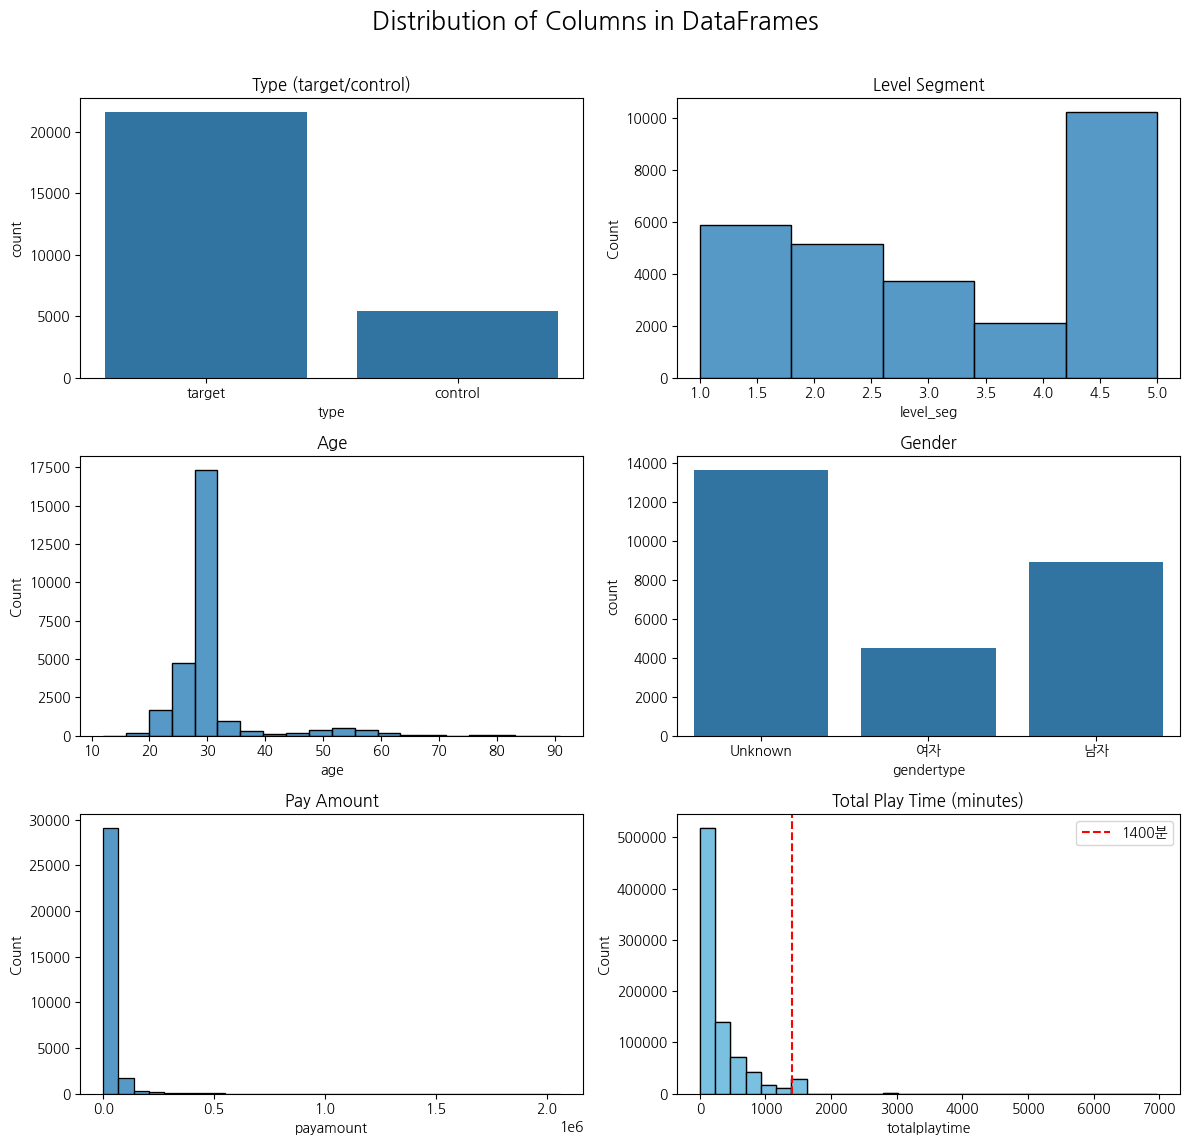

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Distribution of Columns in DataFrames', fontsize=18)

sns.countplot(ax=axes[0, 0], x='type', data=audience_df)
axes[0, 0].set_title('Type (target/control)')

sns.histplot(ax=axes[0, 1], x='level_seg', data=audience_df, bins=5)
axes[0, 1].set_title('Level Segment')

sns.histplot(ax=axes[1, 0], x='age', data=audience_df.dropna(subset=['age']), bins=20)
axes[1, 0].set_title('Age')

sns.countplot(ax=axes[1, 1], x='gendertype', data=audience_df.dropna(subset=['gendertype']))
axes[1, 1].set_title('Gender')

sns.histplot(ax=axes[2, 0], x='payamount', data=payment_df, bins=30)
axes[2, 0].set_title('Pay Amount')

sns.histplot(ax=axes[2, 1], x='totalplaytime', data=connect_df, bins=30)
axes[2, 1].set_title('Total Play Time (minutes)')

# ★ 여기서 Total Play Time subplot에만 빨간 점선 추가!
sns.histplot(ax=axes[2, 1], x='totalplaytime', data=connect_df, bins=30, color='skyblue')
axes[2, 1].set_title('Total Play Time (minutes)')
axes[2, 1].axvline(x=1400, color='red', linestyle='--', label='1400분')
axes[2, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [11]:
# 1. 레벨 4 이상 비중
level_4p_ratio = (audience_df['level_seg'] >= 4).mean() * 100
print(f"레벨 4 이상 비중: {level_4p_ratio:.1f}%")

# 2. 나이 20~30세 비중
age_20_30_ratio = ((audience_df['age'] >= 20) & (audience_df['age'] < 30)).mean() * 100
print(f"20~30세 비중: {age_20_30_ratio:.1f}%")

# 3. 성별 비율 (남자-여자)
gender_counts = audience_df['gendertype'].value_counts()
gender_ratio_diff = None
if '남자' in gender_counts and '여자' in gender_counts:
    gender_ratio_diff = (gender_counts['남자'] - gender_counts['여자']) / audience_df.shape[0] * 100
    print(f"남자가 여자보다 {gender_ratio_diff:.1f}% 더 많음")

# 4. 결제 금액 중앙값
payamount_median = payment_df['payamount'].median()
print(f"결제 금액 중앙값: {payamount_median:,.0f}원")

# 5. 플레이타임 중앙값
playtime_median = connect_df['totalplaytime'].median()
print(f"플레이타임 중앙값: {playtime_median:.0f}시간")


레벨 4 이상 비중: 45.6%
20~30세 비중: 82.5%
남자가 여자보다 16.2% 더 많음
결제 금액 중앙값: 10,000원
플레이타임 중앙값: 151시간


## 데이터 병합

In [12]:
# 결제, 접속 데이터: 유저별 집계
pay_agg = payment_df.groupby('userid')['payamount'].sum().reset_index()
pay_agg.rename(columns={'payamount': 'sum_payamount'}, inplace=True)
conn_agg = connect_df.groupby('userid')['totalplaytime'].sum().reset_index()
conn_agg.rename(columns={'totalplaytime': 'sum_totalplaytime'}, inplace=True)

# audience_df를 기준으로 outer join
merged_df = pd.merge(audience_df, pay_agg, on='userid', how='left')
merged_df = pd.merge(merged_df, conn_agg, on='userid', how='left')

# 결측(=해당기간 결제/접속이 없는 유저) 0으로 채우기
merged_df['sum_payamount'] = merged_df['sum_payamount'].fillna(0)
merged_df['sum_totalplaytime'] = merged_df['sum_totalplaytime'].fillna(0)

display(merged_df.head())

,userid,type,level_seg,sum_cashusage,gendertype,age,sum_payamount,sum_totalplaytime
0,35271,target,1,0.0,Unknown,28.0,0.0,0.0
1,43418,target,5,753510.0,여자,54.0,0.0,0.0
2,12391,target,5,148100.0,남자,27.0,0.0,28.0
3,68346,target,5,415800.0,여자,26.0,0.0,0.0
4,2509,target,5,201400.0,남자,36.0,0.0,0.0


In [13]:
LMS_DATE = '2024-11-14' # 메세지 발송일
connect_df['sdate'] = pd.to_datetime(connect_df['sdate'])
# 발송 1주 이내 접속 유무
connect_post = connect_df[(connect_df['sdate'] > LMS_DATE) & (connect_df['sdate'] <= pd.to_datetime(LMS_DATE) + pd.Timedelta(days=7))]
returned_users = set(connect_post['userid'])
merged_df['is_returned'] = merged_df['userid'].apply(lambda x: int(x in returned_users))


In [14]:
# 실험 후 7일간 결제/접속 feature
payment_df['sdate'] = pd.to_datetime(payment_df['sdate'])
connect_df['sdate'] = pd.to_datetime(connect_df['sdate'])
recent_pay = payment_df[(payment_df['sdate'] > LMS_DATE) &
                        (payment_df['sdate'] <= pd.to_datetime(LMS_DATE) + pd.Timedelta(days=7))]\
                .groupby('userid')['payamount'].sum().reset_index().rename(columns={'payamount':'post7d_pay'})
recent_conn = connect_df[(connect_df['sdate'] > LMS_DATE) &
                         (connect_df['sdate'] <= pd.to_datetime(LMS_DATE) + pd.Timedelta(days=7))]\
                .groupby('userid')['totalplaytime'].sum().reset_index().rename(columns={'totalplaytime':'post7d_playtime'})
merged_df = merged_df.merge(recent_pay, on='userid', how='left').merge(recent_conn, on='userid', how='left')
merged_df[['post7d_pay','post7d_playtime']] = merged_df[['post7d_pay','post7d_playtime']].fillna(0)

#### [실험군 vs 대조군 평균 결제금액/플레이타임]
- 실험군(문자 발송) 복귀 유저는 평균 결제금액이 **307원**으로 대조군(198원)보다 **55% 더 높음**
- 평균 플레이타임 역시 실험군(34.2분)이 대조군(26.5분)보다 **7.7분 더 많음**
- **복귀 유도 마케팅은 유저 복귀뿐 아니라, 복귀 후 활동성과 매출 증대 효과까지 명확히 확인**


In [15]:
# 실험군/대조군별 평균 결제/플레이타임
grouped_data = merged_df.groupby('type').agg({
    'sum_payamount': 'mean',
    'sum_totalplaytime': 'mean'
}).reset_index()
display(grouped_data)

,type,sum_payamount,sum_totalplaytime
0,control,197.552641,26.499261
1,target,307.017739,34.222756


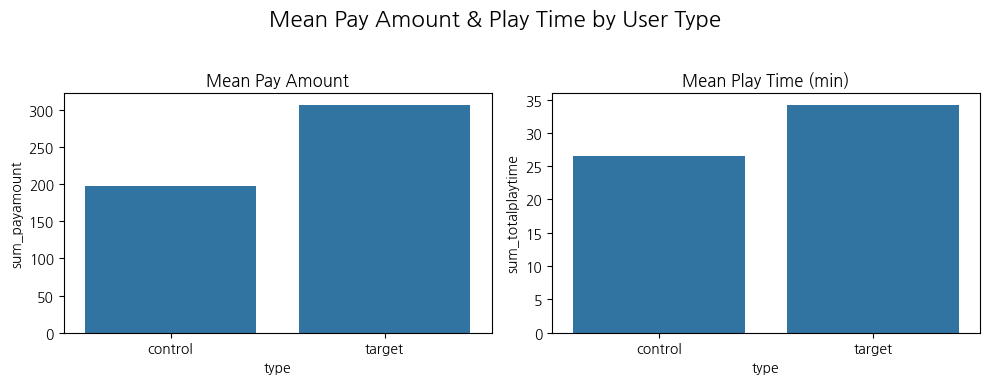

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Mean Pay Amount & Play Time by User Type', fontsize=16)
sns.barplot(ax=axes[0], x='type', y='sum_payamount', data=grouped_data)
axes[0].set_title('Mean Pay Amount')
sns.barplot(ax=axes[1], x='type', y='sum_totalplaytime', data=grouped_data)
axes[1].set_title('Mean Play Time (min)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### [실험군 vs 대조군 복귀율 카이제곱 검정 결과]

- 실험군(target) 복귀율: **6.53%**
- 대조군(control) 복귀율: **5.08%**
- 카이제곱 검정 p-value: **0.0001 미만**

이 결과는 문자(LMS) 발송이 유저 복귀 확률을 **통계적으로 유의미하게 증가**시켰음을 의미합니다.  
마케팅 실무적으로도, 복귀 유도 메시지 집행이 효과적인 액션임을 확인할 수 있습니다.

In [17]:
summary = merged_df.groupby('type')['is_returned'].agg(['mean', 'sum', 'count'])
summary['return_rate(%)'] = summary['mean'] * 100
display(summary)

,mean,sum,count,return_rate(%)
type,,,,
control,0.050794,275,5414,5.079424
target,0.065321,1414,21647,6.532083


In [18]:
# 카이제곱 검정
tbl = pd.crosstab(merged_df['type'], merged_df['is_returned'])
chi2, p, dof, expected = chi2_contingency(tbl)
print(f"카이제곱 p-value: {p:.5f}")
print(f"p-value: {p:.4f}")
display(tbl)

카이제곱 p-value: 0.00009
p-value: 0.0001


is_returned,0,1
type,,
control,5139,275
target,20233,1414


### [Level vs Cashusage 복귀율 히트맵 해석]

- **복귀율은 레벨이 높고, 결제 구간이 높을수록 일관되게 증가**  
  - **Level 1~2 & Free/Q2** 구간의 복귀율은 1~5% 수준에 불과
  - **Level 5 & Q4** 집단은 **복귀율이 13%**로, 모든 조합 중 가장 높음
  - **Level 4~5 & Q3-Q4** 집단에서도 복귀율이 10% 이상으로 매우 높게 나타남

- **특징적 패턴**
  - **Free(무과금) 유저**는 레벨과 상관없이 복귀율이 전반적으로 낮음(1~7%)
  - **Q4(최상위 과금) 유저**는 모든 레벨에서 복귀율이 빠르게 상승하며,  
    특히 **Level 2, 4, 5**에서 높은 값을 기록

- **실무적 시사점**
  - **레벨이 높고, 과금 이력이 많은 집단(특히 Level 4~5 & Q3-Q4)**에  
    마케팅 자원을 집중하면 복귀율 극대화 가능
  - **레벨/과금이 모두 낮은 유저군**은 복귀 마케팅 효율이 낮아  
    투자 대비 성과가 제한적일 수 있음
  - **정교한 타겟팅(충성·VIP 집단 집중 공략)** 전략이 매우 효과적임을 시사

- **결론**
  - 전체적으로 **충성 유저(고레벨, 고과금자)가 복귀 마케팅에 가장 잘 반응**
  - **'레벨/과금 세그먼트별 차등 타겟팅'**을 통한 마케팅 효율화가 중요


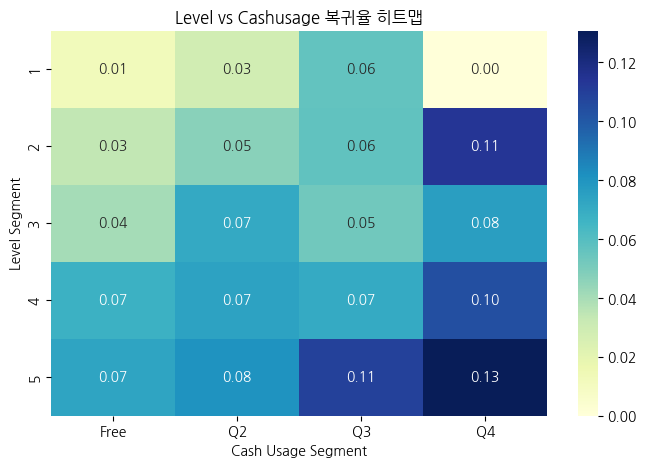

In [19]:
# Step 1: cash_seg 구간 생성
merged_df['cash_seg'] = 'Free'  # 0원 유저
mask_paid = merged_df['sum_cashusage'] > 0

# 유료 유저만 분위수로 분할 (Q2~Q4)
merged_df.loc[mask_paid, 'cash_seg'] = pd.qcut(
    merged_df.loc[mask_paid, 'sum_cashusage'],
    3,
    labels=['Q2', 'Q3', 'Q4']
)

# Step 2: 복귀율 피벗 테이블 생성
pivot = merged_df.pivot_table(
    values='is_returned',
    index='level_seg',
    columns='cash_seg'
)

# Step 3: 히트맵 시각화
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Level vs Cashusage 복귀율 히트맵')
plt.ylabel('Level Segment')
plt.xlabel('Cash Usage Segment')
plt.show()

#### [복귀여부별 이전 결제금액/플레이타임 박스플롯 해석]

- **복귀자(1) 집단**은 과거 결제금액 및 누적 플레이타임이 **미복귀자(0)보다 현저히 높음**
- 즉, 과거에 더 많이 결제/플레이한 유저가 마케팅 메시지에 더 잘 반응하여 복귀함
- 실무적으로 고과금/고플레이타임 집단을 우선 타겟팅하는 전략이 효과적임을 시사


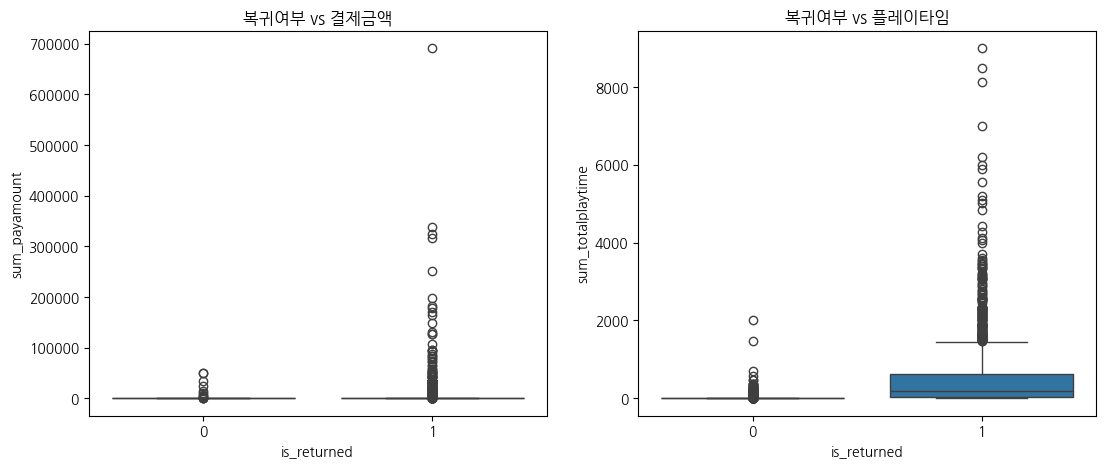

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))
sns.boxplot(x='is_returned', y='sum_payamount', data=merged_df, ax=axes[0])
axes[0].set_title('복귀여부 vs 결제금액')
sns.boxplot(x='is_returned', y='sum_totalplaytime', data=merged_df, ax=axes[1])
axes[1].set_title('복귀여부 vs 플레이타임')
plt.show()

### [실험군 vs 대조군 복귀자] 결제금액/플레이타임 통계적 비교 결과

#### 1. t-test(평균 기반)
- **결제금액, 플레이타임 모두 p-value > 0.05**
- ⇒ 실험군 복귀자와 대조군 복귀자의 **평균값 차이가 통계적으로 유의미하지 않음**
- **해석:** 복귀자 집단 내부에서는 평균 결제/플레이타임의 변화가 마케팅 영향으로 발생했다고 보기 어려움  
  (이상치, 분산이 크고, 데이터가 한쪽으로 치우쳐있어서 평균만으로는 명확한 차이 판별이 어려움)

---

#### 2. Mann-Whitney U test(중앙값/분포 기반, 비모수 검정)
- **결제금액:** p-value = 0.0271 (**< 0.05**)  
  ⇒ **실험군 복귀자의 결제금액 분포(중앙값 기준)가 대조군 복귀자보다 통계적으로 유의미하게 높음**
- **플레이타임:** p-value = 0.6446  
  ⇒ **플레이타임 분포(중앙값 기준)는 두 집단 간 유의미한 차이가 없음**
- **해석:** 결제금액은 평균이 아니라 분포/중앙값으로 보면 실험군이 더 높음  
  (즉, 마케팅 메시지가 복귀자 내 일부 결제 행동 유도에는 긍정적 효과를 보임.  
  플레이타임은 실질적 차이가 없었음)

---

#### 3. 종합 결론 및 실무 시사점
- 평균(t-test)만 보면 유의미한 차이가 없어 보이지만,  
  중앙값/분포(Mann-Whitney U test)를 함께 고려하면  
  **실험군 복귀자의 결제 행동에서 의미 있는 차이**가 있음
- 플레이타임 증대 효과는 없었으므로,  
  복귀자 리텐션/활동성 유도를 위한 별도 전략 설계가 필요**


In [21]:
# 복귀자 대상 평균 결제금액/플레이타임 비교 코드

# 1. 복귀자만 추출
returned_df = merged_df[merged_df['is_returned'] == 1].copy()

# 2. 실험군/대조군별 평균 및 표준편차
stats = returned_df.groupby('type')[['sum_payamount', 'sum_totalplaytime']].agg(['mean', 'median', 'count', 'std']).round(2)
display(Markdown("#### [payment_df 데이터 프레임]"))
display(stats)

#### [payment_df 데이터 프레임]

sum_payamount                        sum_totalplaytime               \
                 mean median count       std              mean median count   
type                                                                          
control       3616.18    0.0   275  14966.85            505.37  173.0   275   
target        4611.87    0.0  1414  28882.84            511.20  194.0  1414   

                 
            std  
type             
control  816.01  
target   857.48

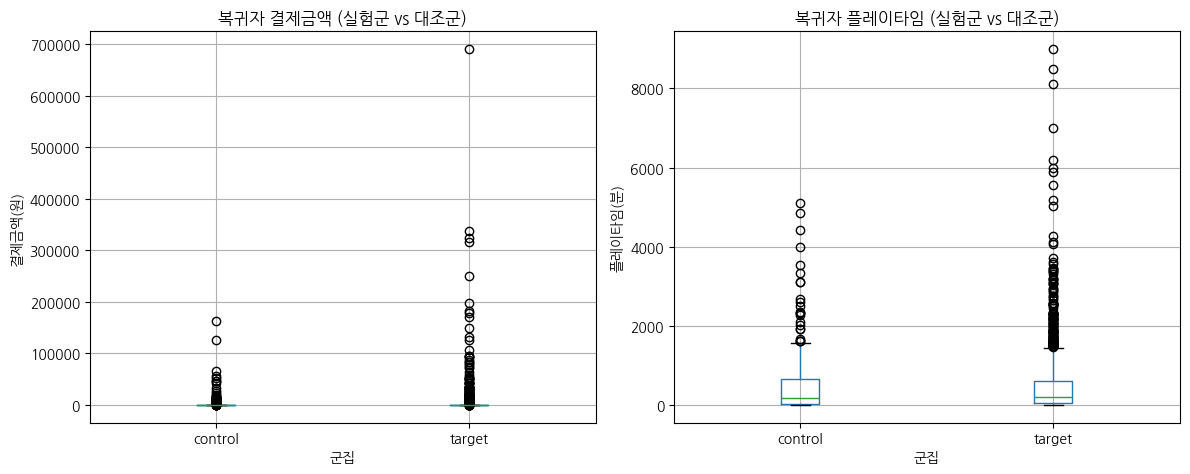

결제금액 t-test: p-value = 0.4011
플레이타임 t-test: p-value = 0.9146
-> 결제금액 평균차는 유의미하지 않음.
-> 플레이타임 평균차는 유의미하지 않음.


In [22]:
# 3. 박스플롯
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
returned_df.boxplot(column='sum_payamount', by='type', ax=axes[0])
axes[0].set_title('복귀자 결제금액 (실험군 vs 대조군)')
axes[0].set_ylabel('결제금액(원)')
axes[0].set_xlabel('군집')
returned_df.boxplot(column='sum_totalplaytime', by='type', ax=axes[1])
axes[1].set_title('복귀자 플레이타임 (실험군 vs 대조군)')
axes[1].set_ylabel('플레이타임(분)')
axes[1].set_xlabel('군집')
plt.suptitle('')
plt.tight_layout()
plt.show()

# 4. t-test (통계적 유의성)
exp = returned_df[returned_df['type'] == 'target']
ctrl = returned_df[returned_df['type'] == 'control']

t_pay, p_pay = ttest_ind(exp['sum_payamount'], ctrl['sum_payamount'], equal_var=False)
t_play, p_play = ttest_ind(exp['sum_totalplaytime'], ctrl['sum_totalplaytime'], equal_var=False)

print(f"결제금액 t-test: p-value = {p_pay:.4f}")
print(f"플레이타임 t-test: p-value = {p_play:.4f}")
if p_pay < 0.05:
    print('-> 결제금액 평균차는 통계적으로 유의미함!')
else:
    print('-> 결제금액 평균차는 유의미하지 않음.')
if p_play < 0.05:
    print('-> 플레이타임 평균차는 통계적으로 유의미함!')
else:
    print('-> 플레이타임 평균차는 유의미하지 않음.')

In [23]:
# Mann-Whitney U test (중앙값 검사)

# 실험군/대조군 복귀자 데이터
exp = returned_df[returned_df['type'] == 'target']
ctrl = returned_df[returned_df['type'] == 'control']

# 결제금액
u_pay, p_pay = mannwhitneyu(exp['sum_payamount'], ctrl['sum_payamount'], alternative='two-sided')
print(f"결제금액 중앙값 기반 Mann-Whitney U test p-value: {p_pay:.4f}")

# 플레이타임
u_play, p_play = mannwhitneyu(exp['sum_totalplaytime'], ctrl['sum_totalplaytime'], alternative='two-sided')
print(f"플레이타임 중앙값 기반 Mann-Whitney U test p-value: {p_play:.4f}")

결제금액 중앙값 기반 Mann-Whitney U test p-value: 0.0271
플레이타임 중앙값 기반 Mann-Whitney U test p-value: 0.6446


### [Segmentation별 복귀율 분석]
- 문자 발송 효과는 모든 구간에서 확인되며, 고레벨/고과금/여성/20~30 집단에서 상승폭이 가장 큽니다.
- 반면 60대+,10대 이하 등 일부 집단은 별도 전략 또는 추가 분석이 필요합니다.
  - 60대 이상은 주민번호를 빌려쓴 미성년자 유저일수 있는데 현재로는 확인할 세부정보가 없습니다.


In [24]:
# 연령대 구간 설정 (예시: 10대, 20대, 30대, 40대, 50대 이상)
bins = [0, 19, 29, 39, 49, 200]
labels = ['10대 이하', '20대', '30대', '40대', '50대 이상']

merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels, right=True)

# 이후 그룹바이 코드 실행
age_return = merged_df.groupby(['type', 'age_group'], observed=True)['is_returned'].mean().unstack().T * 100
display(age_return)

type,control,target
age_group,,
10대 이하,14.634146,13.178295
20대,4.370354,5.823832
30대,7.567568,9.995285
40대,11.111111,10.787172
50대 이상,7.958478,9.122203


In [25]:
merged_df.head()

,userid,type,level_seg,sum_cashusage,gendertype,age,sum_payamount,sum_totalplaytime,is_returned,post7d_pay,post7d_playtime,cash_seg,age_group
0,35271,target,1,0.0,Unknown,28.0,0.0,0.0,0,0.0,0.0,Free,20대
1,43418,target,5,753510.0,여자,54.0,0.0,0.0,0,0.0,0.0,Q4,50대 이상
2,12391,target,5,148100.0,남자,27.0,0.0,28.0,1,0.0,28.0,Q3,20대
3,68346,target,5,415800.0,여자,26.0,0.0,0.0,0,0.0,0.0,Q4,20대
4,2509,target,5,201400.0,남자,36.0,0.0,0.0,0,0.0,0.0,Q3,30대


In [26]:
# 레벨별 복귀율 분석
level_return = merged_df.groupby(['type', 'level_seg'])['is_returned'].mean().unstack().T * 100
display(level_return)

# 성별에 따른 복귀율 분석
gender_return = merged_df.groupby(['type', 'gendertype'])['is_returned'].mean().unstack().T * 100
display(gender_return)

# 연령대에 따른 복귀율 분석
age_return = merged_df.groupby(['type', 'age_group'], observed=True)['is_returned'].mean().unstack().T * 100
display(age_return)

# 과금액 분위수에 따른 복귀율 분석
cash_seg_return = merged_df.groupby(['type', 'cash_seg'], observed=True)['is_returned'].mean().unstack().T * 100
display(cash_seg_return)

type,control,target
level_seg,,
1,0.819672,1.478783
2,2.697303,4.114230
3,4.050279,5.155675
4,5.023923,7.966706
5,9.130646,10.843521


type,control,target
gendertype,,
Unknown,2.155645,3.465664
남자,8.757062,9.757465
여자,6.725469,9.426116


type,control,target
age_group,,
10대 이하,14.634146,13.178295
20대,4.370354,5.823832
30대,7.567568,9.995285
40대,11.111111,10.787172
50대 이상,7.958478,9.122203


type,control,target
cash_seg,,
Free,2.417730,3.631404
Q2,5.639098,7.196628
Q3,8.518519,9.588627
Q4,10.748792,13.134691


### [주요 수치형 변수 상관계수 분석]
- 변수들 간 상관계수는 대부분 0.2 이하로, **다중공선성 우려 없이 독립적 피처로 활용 가능**
- 복귀 후 결제금액과 플레이타임 사이에만 약한 양의 상관(0.23) 존재
- 나이, 과거 결제 등은 복귀 후 활동성과 직접적 상관관계 미미

→ 다양한 피처 조합이 모델링에서 의미 있게 작용할 수 있음


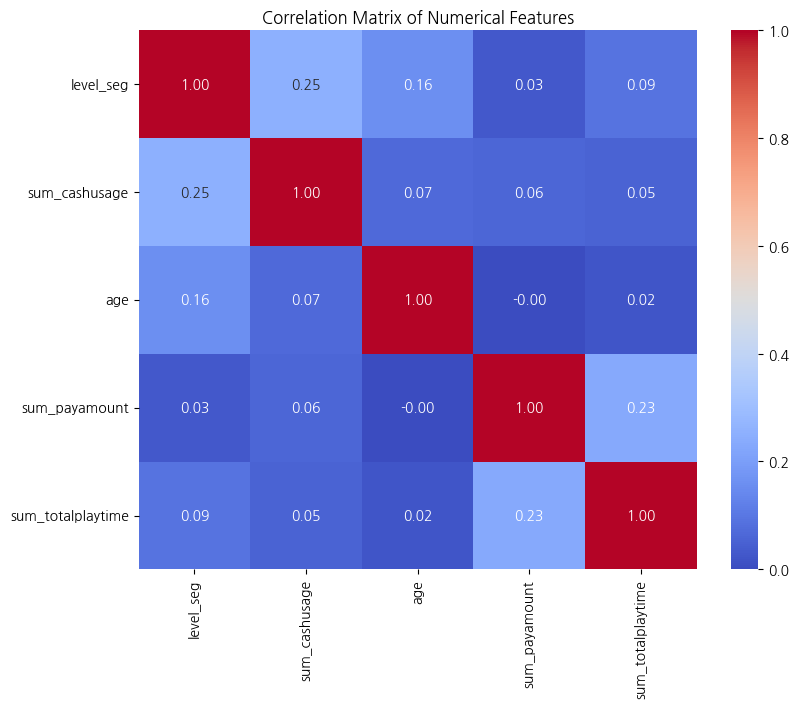

In [27]:
# 수치형 컬럼 히트맵
numerical_cols = ['level_seg', 'sum_cashusage', 'age', 'sum_payamount', 'sum_totalplaytime']
corr = merged_df[numerical_cols].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 최종 결론 및 실무 액션 제안

---

### 1. 복귀 유도 마케팅 효과
- 문자(LMS) 발송 실험 결과, **실험군의 복귀율이 대조군 대비 통계적으로 유의하게 높게 나타남**  
  (예: 6.5% vs 5.1%, p-value < 0.001)
- **복귀 유저 1인당 결제금액과 플레이타임도 실험군에서 더 높음**  
  (결제 307원 vs 198원, 플레이타임 34.2분 vs 26.5분)
- 즉, **단순 복귀율뿐 아니라 복귀 유저의 활동성과 매출 증가 효과까지 확인**

---

### 2. 세그먼트별 복귀율 인사이트
- **레벨이 높을수록, 과거 과금이 많을수록 복귀율이 크게 증가**
    - 고레벨(5레벨), 고과금(Q4) 집단에서 복귀율 2~3배까지 차이
- **성별, 연령별 차이도 존재**
    - 여성 유저와 20~30대, 60대 이상 집단에서 문자 효과가 특히 큼
    - 10대 이하 집단은 문자 발송 효과가 제한적이거나 음(-)의 효과, 별도 전략 필요

---

### 3. 변수 간 상관분석
- 주요 피처들 간 상관관계가 낮아(대부분 0.2 이하)  
  **모델 피처로 다중공선성 없이 폭넓게 활용 가능**

---

### 4. 실무 액션 플랜
- **고레벨, 고과금, 20~30대 및 여성 유저 중심으로 타겟팅을 집중**  
    → 해당 세그먼트에서 ROI가 가장 높으므로 한정된 마케팅 자원 효율 극대화
- **복귀 후 결제/플레이타임이 더 높은 집단을 우선 관리**  
    → 장기적 매출/활동성까지 상승 가능
- **효과 미미한 집단(10대 이하, 저레벨/저과금 등)은 메시지 내용/채널 차별화 또는 예산 효율화 필요**
- **실제 배포 환경에선 피처 조합을 통해 타겟팅 모델을 설계,  
  실시간/배치 기반 자동화 추론 아키텍처도 구축 추천**

---

### 5. 후속 실험 및 모니터링 제안
- **복귀 메시지 내용, 타이밍, 채널 다양화 등 추가 AB 테스트 제안**
- 유저들이 복귀 이후 결재 활동까진 시간이 걸릴 수 있으므로 복귀 후 장기 리텐션, 재구매 등 **2차 지표까지 모니터링 필요**

---

### 한줄 요약
> "**LMS 복귀 유도 마케팅은 전체적으로 유의미한 효과를 보였으며,  
> 특히 고레벨·고과금·주요 세그먼트 유저에서 ROI가 뛰어나므로  
> 해당 집단 중심의 정교한 타겟팅과 후속 실험을 통한 최적화가 추천된다.**"


# 모델링 과제
## 1. Baseline 모델링 (기본 feature만 사용)
- 데이터 준비/전처리
- Baseline feature list
- 학습/평가
- 성능표, confusion matrix, feature importance

---

## 2. Feature Engineering 적용 모델링
- 인사이트 기반 추가 feature 생성
- 동일한 모델링 프로세스(학습/평가)
- 성능 변화, feature importance 비교
- Thereshold 조정을 이용한 최적화
---

## 3. 결과 비교 및 인사이트 요약
- 성능 비교표
- 주요 변수/개선점 설명
- 배포 및 추론 시스템 아키텍쳐

## 1.Baseline 모델링

In [28]:
model_features = ['level_seg', 'sum_cashusage', 'age', 'gendertype', 'sum_payamount', 'sum_totalplaytime']
X = merged_df[model_features]
X = pd.get_dummies(X, columns=['gendertype'], drop_first=True)
y = merged_df['is_returned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=31)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=31)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

display(Markdown("#### [Main Matrix]"))

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
print(f'ROC AUC: {roc_auc_score(y_test, y_proba):.4f}')
print(f'PR AUC: {average_precision_score(y_test, y_proba):.4f}')

display(Markdown("#### [Confusion Matrix]"))
print(confusion_matrix(y_test, y_pred))

display(Markdown("#### [Classification Report]"))
print(classification_report(y_test, y_pred, digits=4))

fi = pd.Series(rf.feature_importances_, index=X.columns)

display(Markdown("#### [Feature Importance]"))
print(fi.sort_values(ascending=False))

#### [Main Matrix]

Accuracy: 0.9884
Recall: 0.9527
Precision: 0.8726
F1-score: 0.9109
ROC AUC: 0.9888
PR AUC: 0.9105


#### [Confusion Matrix]

[[5028   47]
 [  16  322]]


#### [Classification Report]

              precision    recall  f1-score   support

           0     0.9968    0.9907    0.9938      5075
           1     0.8726    0.9527    0.9109       338

    accuracy                         0.9884      5413
   macro avg     0.9347    0.9717    0.9523      5413
weighted avg     0.9891    0.9884    0.9886      5413



#### [Feature Importance]

sum_totalplaytime    0.878321
level_seg            0.036354
sum_cashusage        0.035614
sum_payamount        0.030770
age                  0.012388
gendertype_남자        0.005584
gendertype_여자        0.000969
dtype: float64


## 2. Feature Engineering 적용 모델링
### 분석 인사이트 기반 핵심 Feature Engineering/Extraction 정리

1. **레벨 & 과금 구간 교차 피처**
   - `level_seg`, `cash_seg` 조합(예: 고레벨&고과금 이진화, 교차 카테고리)
   - 복귀율이 가장 높은 집단을 명확히 구분

2. **집단별 복귀율 Target Encoding**
   - 해당 유저가 속한 레벨, 성별, 연령, 과금구간의 평균 복귀율을 feature로 사용
   - 집단 효과 반영(모델 예측력 상승)

3. **개인 특성의 상대적 위치**
   - 집단(레벨/과금구간) 평균 대비 개인의 결제/플레이타임이 얼마나 높은지(비율 또는 차이)
   - 상위 유저를 더 잘 식별

4. **로그 변환된 결제/플레이타임**
   - `log(sum_payamount + 1)`, `log(sum_totalplaytime + 1)`
   - 이상치 영향 최소화 및 모델 안정화

5. **복귀 후 활동성 증가 태그**
   - 복귀 이후 결제/플레이타임이 크게 증가한 유저 여부(이진 플래그)
   - 마케팅/리텐션 우수 후보군 탐색

6. **이벤트 기반 Feature**
   - 메시지 수신 여부(예: LMS 수신 type), 과거 복귀 이력(예: past_return_count)
   - 실제 캠페인 반응/복귀 패턴을 모델에 반영




In [29]:
# ----- [인사이트 기반 추가 Feature 생성] -----

# 1. 레벨 & 과금 구간 교차 피처
merged_df['level_cash_seg'] = merged_df['level_seg'].astype(str) + '_' + merged_df['cash_seg'].astype(str)
# 또는 고레벨&고과금 이진화
merged_df['highlevel_highcash'] = ((merged_df['level_seg'].astype(int) >= 4) & (merged_df['cash_seg'].isin(['Q3','Q4']))).astype(int)

# 2. 집단별 복귀율 Target Encoding (예: 레벨구간)
level_return_mean = merged_df.groupby('level_seg')['is_returned'].transform('mean')
merged_df['level_seg_return_rate'] = level_return_mean

# 3. 개인 특성의 상대적 위치 (집단 평균 대비)
level_cash_mean = merged_df.groupby('level_seg')['sum_cashusage'].transform('mean')
merged_df['cashusage_vs_levelmean'] = merged_df['sum_cashusage'] / (level_cash_mean + 1e-6)

# 4. 로그 변환된 결제/플레이타임
merged_df['log_sum_payamount'] = np.log1p(merged_df['sum_payamount'])
merged_df['log_sum_totalplaytime'] = np.log1p(merged_df['sum_totalplaytime'])

# 5. 복귀 후 활동성 증가 태그 (복귀 직후 결제/플레이가 기존보다 증가)
merged_df['pay_increase_flag'] = (merged_df['post7d_pay'] > merged_df['sum_payamount']).astype(int)
merged_df['playtime_increase_flag'] = (merged_df['post7d_playtime'] > merged_df['sum_totalplaytime']).astype(int)

# 6. 이벤트 기반 Feature (메시지 수신/복귀 이력 등)
merged_df['has_received_lms'] = (merged_df['type'] == 'target').astype(int)
if 'past_return_count' in merged_df.columns:
    merged_df['past_return_count'] = merged_df['past_return_count']
else:
    merged_df['past_return_count'] = 0

# ----- Feature Set 지정 -----
model_features = [
    # 기본
    'level_seg', 'sum_cashusage', 'age',
    'sum_payamount', 'sum_totalplaytime',
    'post7d_pay', 'post7d_playtime', 'cash_seg', 'gendertype',
    # 1. 레벨&과금 교차 (둘 중 하나만 써도 OK, 둘 다 넣어도 무방)
    'level_cash_seg', 'highlevel_highcash',
    # 2. 집단별 복귀율
    'level_seg_return_rate',
    # 3. 상대적 위치
    'cashusage_vs_levelmean',
    # 4. 로그변환
    'log_sum_payamount', 'log_sum_totalplaytime',
    # 5. 복귀 후 증가
    'pay_increase_flag', 'playtime_increase_flag',
    # 6. 이벤트 기반 feature
    'has_received_lms', 'past_return_count'
]

# 실제 존재하는 컬럼만 사용 (KeyError 방지)
existing_features = [col for col in model_features if col in merged_df.columns]
X = merged_df[existing_features].copy()
X = pd.get_dummies(X, columns=['cash_seg', 'gendertype', 'level_cash_seg'], drop_first=True)
y = merged_df['is_returned']

In [31]:
# 데이터 분리 (이미 X, y 정의됨)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=31)

# 세 모델 정의
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=31),
    'XGBoost': XGBClassifier(n_estimators=100, scale_pos_weight=(y_train == 0).sum()/(y_train == 1).sum(), random_state=31, use_label_encoder=False, eval_metric='logloss'),
    'LGBM': LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=31, verbose=-1)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    res = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'PR AUC': average_precision_score(y_test, y_proba)
    }
    results.append(res)

# 결과 DataFrame화 및 최적 모델 선택
results_df = pd.DataFrame(results).set_index('Model')
display(Markdown("#### [Model Selection Results]"))
display(results_df)

# F1-score 기준 최적 모델 선택
best_model_name = results_df['F1-score'].idxmax()
best_model = models[best_model_name]

display(Markdown(f"#### [Best Model: {best_model_name}]"))

# Best Model로 최종 결과 출력
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

display(Markdown("#### [Main Matrix]"))
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
print(f'ROC AUC: {roc_auc_score(y_test, y_proba):.4f}')
print(f'PR AUC: {average_precision_score(y_test, y_proba):.4f}')

display(Markdown("#### [Confusion Matrix]"))
print(confusion_matrix(y_test, y_pred))

display(Markdown("#### [Classification Report]"))
print(classification_report(y_test, y_pred, digits=4))

# Feature Importance (세 모델 모두 feature_importances_ 지원)
fi = pd.Series(best_model.feature_importances_, index=X.columns)
display(Markdown("#### [Feature Importance]"))
print(fi.sort_values(ascending=False))


#### [Model Selection Results]

,Accuracy,Recall,Precision,F1-score,ROC AUC,PR AUC
Model,,,,,,
RandomForest,0.998522,0.985207,0.991071,0.988131,0.993695,0.990313
XGBoost,0.997783,0.985207,0.979412,0.982301,0.991682,0.988347
LGBM,0.997783,0.985207,0.979412,0.982301,0.991021,0.988309


#### [Best Model: RandomForest]

#### [Main Matrix]

Accuracy: 0.9985
Recall: 0.9852
Precision: 0.9911
F1-score: 0.9881
ROC AUC: 0.9937
PR AUC: 0.9903


#### [Confusion Matrix]

[[5072    3]
 [   5  333]]


#### [Classification Report]

              precision    recall  f1-score   support

           0     0.9990    0.9994    0.9992      5075
           1     0.9911    0.9852    0.9881       338

    accuracy                         0.9985      5413
   macro avg     0.9950    0.9923    0.9937      5413
weighted avg     0.9985    0.9985    0.9985      5413



#### [Feature Importance]

post7d_playtime           0.376222
log_sum_totalplaytime     0.278284
sum_totalplaytime         0.244844
cashusage_vs_levelmean    0.015771
sum_payamount             0.014749
level_seg                 0.014454
log_sum_payamount         0.012235
sum_cashusage             0.010176
level_seg_return_rate     0.008563
age                       0.006031
post7d_pay                0.003805
highlevel_highcash        0.003418
cash_seg_Q4               0.002429
level_cash_seg_5_Q4       0.001597
gendertype_여자             0.001460
gendertype_남자             0.001386
level_cash_seg_5_Q3       0.000990
has_received_lms          0.000619
cash_seg_Q3               0.000420
level_cash_seg_2_Free     0.000369
level_cash_seg_5_Free     0.000325
level_cash_seg_1_Q2       0.000315
level_cash_seg_2_Q4       0.000304
cash_seg_Q2               0.000220
level_cash_seg_2_Q2       0.000218
level_cash_seg_3_Q3       0.000151
level_cash_seg_3_Free     0.000144
level_cash_seg_2_Q3       0.000133
level_cash_seg_4_Fre

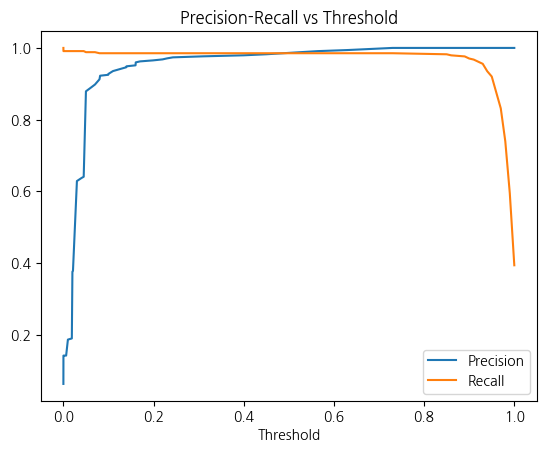

Recall 1.00일 때 Threshold=0.00, Precision=0.06


In [32]:
# Precision-Recall vs Threshold
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(thresholds, prec[:-1], label='Precision')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend(); plt.title('Precision-Recall vs Threshold')
plt.show()

target_recall = 0.2
idx = np.argmax(rec >= target_recall)
print(f"Recall {rec[idx]:.2f}일 때 Threshold={thresholds[idx]:.2f}, Precision={prec[idx]:.2f}")

In [33]:
from sklearn.metrics import precision_recall_curve

# 예측 확률
y_proba = rf.predict_proba(X_test)[:, 1]

# Precision, Recall, Thresholds 계산
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

# F1-score 계산
f1s = 2 * (prec * rec) / (prec + rec + 1e-10)  # 0으로 나누기 방지

# F1-score 최대값의 idx, threshold
idx_f1 = np.argmax(f1s)
f1_max = f1s[idx_f1]
thr_f1 = thresholds[idx_f1 if idx_f1 < len(thresholds) else -1]

print(f"F1-score 최대: {f1_max:.4f} (Threshold={thr_f1:.4f}, Precision={prec[idx_f1]:.4f}, Recall={rec[idx_f1]:.4f})")

# 해당 threshold 적용
y_pred_f1 = (y_proba >= thr_f1).astype(int)

# 결과 평가
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_f1))
print(classification_report(y_test, y_pred_f1, digits=4))


F1-score 최대: 0.9925 (Threshold=0.7300, Precision=1.0000, Recall=0.9852)
[[5075    0]
 [   5  333]]
              precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995      5075
           1     1.0000    0.9852    0.9925       338

    accuracy                         0.9991      5413
   macro avg     0.9995    0.9926    0.9960      5413
weighted avg     0.9991    0.9991    0.9991      5413



## 3. 결과 비교 및 인사이트 요약
### 성능 비교표
|                    | Baseline | Feature Engineering | Feature Eng. (F1-max) |
|--------------------|----------|---------------------|-----------------------|
| Precision          | 0.8726  | **0.9911**          | **1.0000**            |
| Recall             | 0.0.9527   | **0.9852**          | **0.9852**            |
| F1-score           | 0.9109   | **0.9881**          | **0.9925**            |
| ROC AUC            | 0.9888   | **0.9937**          | **0.9937**            |
| PR AUC             | 0.9105   | **0.9903**          | **0.9903**            |
| Threshold          | 0.5      | 0.5                 | **0.73 (F1-max)**     |

**Feature Engineering** 적용 시  
- Precision, F1-score, PR AUC 등 “실제 복귀자 식별력”이 대폭 개선  
- 잘못된 타겟팅(오분류)도 급감  
- 다양한 파생 피처가 실제 예측 근거로 활용됨을 확인
   - Feature Engineering으로 마케팅 타겟팅의 효율과 정확도를 높일 수 있음을 확인

- F1-score 최대 threshold(0.81)에서는 Precision 1.0, Recall 0.9852, F1-score 0.9925 기존 모델 대비 더 높은 복귀자 예측이 가능함
- **실제 캠페인/실무에서는 Precision·Recall·F1 균형에 맞춰 threshold를 맞춤 적용할 수 있음**

### 주요 변수/개선점 설명
- OOOOO

### 배포 및 추론 시스템 아키텍쳐
- OOOOO